# 3D Reconstruction

#### Imports

In [256]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
# from scipy.optimize import least_squares
# add imports here

### Dataset Loading & Preprocessing

In [49]:
import os
import numpy as np
import cv2
images_folder = r"H:\Fall 24\Comp Vision\Project\brandenburg_gate\dense\images"
semantic_maps_folder = r"H:\Fall 24\Comp Vision\Project\brandenburg_gate\semantic_maps"
image_files = sorted([f for f in os.listdir(images_folder) 
                      if f.endswith(('jpg', 'png', 'jpeg')) and not f.startswith("._")])
print(f"Valid image files: {image_files}")
print(len(image_files))
image_paths = [os.path.join(images_folder, image_files[i]) for i in range((len(image_files)))]
images = [cv2.imread(img_path) for img_path in image_paths]
images_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images if img is not None]
print(len(images_rgb))
semantic_maps = []
for image_file in image_files:  
    semantic_map_filename = os.path.splitext(image_file)[0] + ".npz"
    semantic_map_path = os.path.join(semantic_maps_folder, semantic_map_filename)
    if os.path.exists(semantic_map_path):
        data = np.load(semantic_map_path)
        semantic_map = data['arr_0']
        if semantic_map is not None:
            semantic_maps.append(semantic_map)
print(f"Loaded {len(semantic_maps)} semantic maps")


Valid image files: ['00289298_7642283248.jpg', '00315862_6836283050.jpg', '00436870_59297810.jpg', '00581890_3574867299.jpg', '00609395_7226852998.jpg', '00638427_1342162905.jpg', '00787747_3221432213.jpg', '00880621_5104022828.jpg', '00883281_9633489441.jpg', '01054272_4619185109.jpg', '01069771_8567470929.jpg', '01159955_8507720260.jpg', '01473103_2691761403.jpg', '01546257_302490568.jpg', '01587180_6880119979.jpg', '01606261_5217160071.jpg', '01677427_4801156058.jpg', '01738801_5114523193.jpg', '01911720_4970488279.jpg', '02035158_8518636650.jpg', '02147313_8631507684.jpg', '02368960_3585648661.jpg', '02391330_18543837.jpg', '02455830_5635721705.jpg', '02496005_6309820165.jpg', '02516180_10994677186.jpg', '02527216_3379040375.jpg', '02566955_9377454362.jpg', '02749394_3866382383.jpg', '02936509_94852264.jpg', '03028144_6880112453.jpg', '03034452_4601940001.jpg', '03058406_6979024134.jpg', '03147595_9248561918.jpg', '03154363_5457548277.jpg', '03234383_10253641595.jpg', '03300929_279

In [50]:
import cv2
import numpy as np
import random
import os

def get_img_paths(folder_pth):
    jpg_files = []
    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            jpg_files.append(filename)
    return jpg_files

def load_images(folder_pth):
    images = []
    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_pth, filename))
            images.append(img)
    return images

def resize_image(img, size=(600, 400)):
    return cv2.resize(img, size)

def convert_to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def normalize_image(img):
    return cv2.equalizeHist(img)

def bright_image(img, brightness=10, contrast=1.3):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    normalized_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return normalized_img

def undistort_images(input_folder, output_folder, camera_matrix, dist_coeffs):
    for filename in os.listdir(input_folder):
        img = cv2.imread(os.path.join(input_folder, filename))
        if img is not None:
            h, w = img.shape[:2]
            new_camera_matrix, _ = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
            undistorted_img = cv2.undistort(img, camera_matrix, dist_coeffs, None, new_camera_matrix)
            cv2.imwrite(os.path.join(output_folder, filename), undistorted_img)

def augment_images(img):
    rows, cols = img.shape[:2]
    angle = random.uniform(-10, 10)  
    rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    rotated_img = cv2.warpAffine(img, rotation_matrix, (cols, rows))
    return rotated_img

def preprocess_images(images):
    preprocessed_images = []
    for img in images:
        h, w = img.shape[:2]
        resized_img = resize_image(img)
        brightened_img = bright_image(resized_img)
        gray_img = convert_to_grayscale(brightened_img)
        edges = cv2.Canny(gray_img, 100, 200)
        blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
        kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
        sharpened_img = cv2.filter2D(blurred_img, -1, kernel)
        sharpened_img[h//4:h//4 + h//2, w//4:w//4 + w//2] = gray_img[h//4:h//4 + h//2, w//4:w//4 + w//2]
        preprocessed_images.append(sharpened_img)
    return preprocessed_images


In [51]:
preprocessed_images = images
preprocessed_images = preprocess_images(preprocessed_images)
# preprocessed_images = preprocessed_images[:50]
print(len(preprocessed_images))

1363


### Feature Detection & Matching (Across Multiple Images)

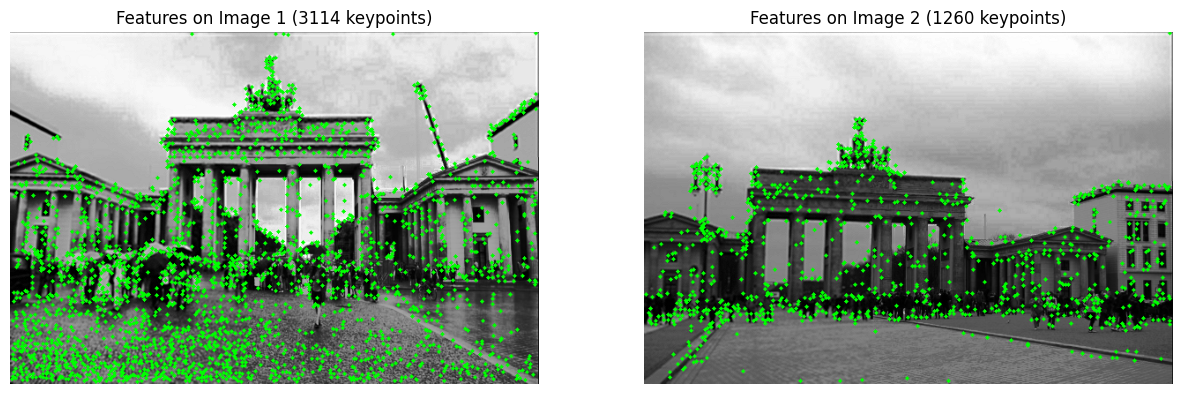

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_and_draw_features(img, semantic_map, class_id=1, algorithm='SIFT'):
    mask = (semantic_map == class_id).astype(np.uint8)
    if algorithm == 'SIFT':
        detector = cv2.SIFT_createdetector = cv2.SIFT_create()              
    elif algorithm == 'ORB':
        detector = cv2.ORB_create()
    else:
        raise ValueError("Unsupported algorithm. Use 'SIFT' or 'ORB'.")
    keypoints, descriptors = detector.detectAndCompute(img, None)
    img_with_keypoints = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        cv2.circle(img_with_keypoints, (x, y), radius=2, color=(0, 255, 0), thickness=-1)
    return img_with_keypoints, keypoints, descriptors
images = preprocessed_images
semantic_maps = semantic_maps
if len(images) != len(semantic_maps):
    raise ValueError("The number of images and semantic maps must be the same.")

for idx, img in enumerate(images):
    if img is None:
        print(f"Image at index {idx} failed to load.")
images = [img for img in images if img is not None]
semantic_maps = [map for map in semantic_maps if map is not None]

if len(images) < 2:
    raise ValueError("Not enough valid images to proceed. Ensure at least two valid images are loaded.")
img1_features, keypoints1, descriptors1 = detect_and_draw_features(images[0], semantic_maps[0], class_id=1, algorithm='SIFT')
img2_features, keypoints2, descriptors2 = detect_and_draw_features(images[1], semantic_maps[1], class_id=1, algorithm='SIFT')
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(img1_features, cmap='gray')
plt.title(f"Features on Image 1 ({len(keypoints1)} keypoints)")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img2_features, cmap='gray')
plt.title(f"Features on Image 2 ({len(keypoints2)} keypoints)")
plt.axis("off")
plt.show()


In [57]:
import cv2
import numpy as np

def detect_and_draw_features(img, semantic_map, class_id=1, algorithm='SIFT'):
    if img is None:
        raise ValueError("Failed to load image.")
    if algorithm == 'SIFT':
        detector = cv2.SIFT_create()
    elif algorithm == 'ORB':
        detector = cv2.ORB_create()
    else:
        raise ValueError("Unsupported algorithm. Use 'SIFT' or 'ORB'.")
    mask = (semantic_map == class_id).astype(np.uint8) * 255
    keypoints, descriptors = detector.detectAndCompute(img, None)
    img_with_keypoints = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        cv2.circle(img_with_keypoints, (x, y), radius=2, color=(0, 255, 0), thickness=-1) 
    return img_with_keypoints, keypoints, descriptors

sampled_images = preprocessed_images

for idx, img in enumerate(sampled_images):
    if img is None:
        print(f"Error: Image at index {idx} failed to load, skipping.")
        continue 
if len(sampled_images) < 2:
    raise ValueError("Not enough valid images to proceed. Ensure at least two valid images are loaded.")
if len(sampled_images) != len(semantic_maps):
    raise ValueError("The number of images and semantic maps must be the same.")
feature_data = []
for idx, img in enumerate(sampled_images):
    if img is None:
        print(f"Error: Image at index {idx} is None, skipping.")
        continue  
    try:
        print(f"{idx}...")
        semantic_map = semantic_maps[idx]
        imgs, keypoints, descriptors = detect_and_draw_features(img, semantic_map, class_id=1, algorithm='SIFT')
        feature_data.append({
            'imgs': imgs,
            'keypoints': keypoints,
            'descriptors': descriptors
        })
    except Exception as e:
        print(f"Error processing image {idx}: {e}")
print(f"Processed {len(feature_data)} images.")


0...
1...
2...
3...
4...
5...
6...
7...
8...
9...
10...
11...
12...
13...
14...
15...
16...
17...
18...
19...
20...
21...
22...
23...
24...
25...
26...
27...
28...
29...
30...
31...
32...
33...
34...
35...
36...
37...
38...
39...
40...
41...
42...
43...
44...
45...
46...
47...
48...
49...
50...
51...
52...
53...
54...
55...
56...
57...
58...
59...
60...
61...
62...
63...
64...
65...
66...
67...
68...
69...
70...
71...
72...
73...
74...
75...
76...
77...
78...
79...
80...
81...
82...
83...
84...
85...
86...
87...
88...
89...
90...
91...
92...
93...
94...
95...
96...
97...
98...
99...
100...
101...
102...
103...
104...
105...
106...
107...
108...
109...
110...
111...
112...
113...
114...
115...
116...
117...
118...
119...
120...
121...
122...
123...
124...
125...
126...
127...
128...
129...
130...
131...
132...
133...
134...
135...
136...
137...
138...
139...
140...
141...
142...
143...
144...
145...
146...
147...
148...
149...
150...
151...
152...
153...
154...
155...
156...
157...
158.

In [68]:
import cv2
import numpy as np

index_params = dict(algorithm=1, trees=10)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches_dict = {}
ratio_threshold = 0.8
for i in range(len(feature_data) - 1):  
    j = i + 1  
    print(f"Matching pair ({i}, {j})")
    descriptors1 = feature_data[i]['descriptors']
    descriptors2 = feature_data[j]['descriptors']
    if descriptors1 is None or descriptors2 is None:
        print(f"Skipping matching for pair ({i}, {j}) due to missing descriptors.")
        continue
    if len(descriptors1) == 0 or len(descriptors2) == 0:
        print(f"Skipping matching for pair ({i}, {j}) due to empty descriptors.")
        continue
    try:
        knn_matches = flann.knnMatch(descriptors1, descriptors2, k=2)
        good_matches = [m for m, n in knn_matches if m.distance < ratio_threshold * n.distance ]
        # if m.distance < ratio_threshold * n.distance
        # good_matches = knn_matches
        if len(good_matches) > 4:
            src_pts = np.float32([feature_data[i]['keypoints'][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([feature_data[j]['keypoints'][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            good_matches = [good_matches[k] for k in range(len(good_matches)) if mask[k] == 1]
            matches_dict[(i, j)] = good_matches
            print(f"Matched images {i} and {j}: {len(good_matches)} good matches after RANSAC.")
        else:
            matches_dict[(i, j)] = good_matches
            print(f"Matched images {i} and {j}: {len(good_matches)} matches.")
    except cv2.error as e:
        print(f"Error in matching images ({i}, {j}): {e}")


Matching pair (0, 1)
Matched images 0 and 1: 32 good matches after RANSAC.
Matching pair (1, 2)
Matched images 1 and 2: 28 good matches after RANSAC.
Matching pair (2, 3)
Matched images 2 and 3: 15 good matches after RANSAC.
Matching pair (3, 4)
Matched images 3 and 4: 29 good matches after RANSAC.
Matching pair (4, 5)
Matched images 4 and 5: 31 good matches after RANSAC.
Matching pair (5, 6)
Matched images 5 and 6: 8 good matches after RANSAC.
Matching pair (6, 7)
Matched images 6 and 7: 10 good matches after RANSAC.
Matching pair (7, 8)
Matched images 7 and 8: 6 good matches after RANSAC.
Matching pair (8, 9)
Matched images 8 and 9: 11 good matches after RANSAC.
Matching pair (9, 10)
Matched images 9 and 10: 10 good matches after RANSAC.
Matching pair (10, 11)
Matched images 10 and 11: 37 good matches after RANSAC.
Matching pair (11, 12)
Matched images 11 and 12: 33 good matches after RANSAC.
Matching pair (12, 13)
Matched images 12 and 13: 9 good matches after RANSAC.
Matching pair 

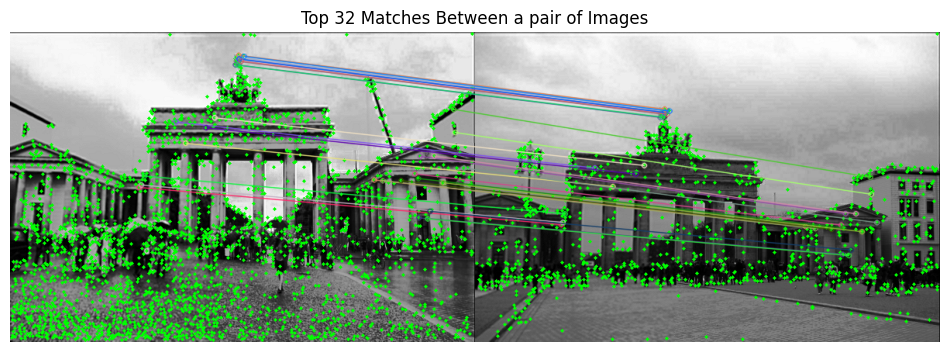

In [69]:
index1, index2 = 0,1
descriptors1 = feature_data[index1]['descriptors']
descriptors2 = feature_data[index2]['descriptors']
if descriptors1 is None or descriptors2 is None:
    raise ValueError(f"Descriptors missing for one or both selected images: {index1}, {index2}.")

matches = matches_dict[(index1, index2)]
img1 = feature_data[index1]['imgs']
img2 = feature_data[index2]['imgs']
kp1 = feature_data[index1]['keypoints']
kp2 = feature_data[index2]['keypoints']
valid_matches = [
    match for match in matches
    if 0 <= match.queryIdx < len(kp1) and 0 <= match.trainIdx < len(kp2)
]

if not valid_matches:
    raise ValueError(f"No valid matches found between Image {index1} and Image {index2}.")

matched_image = cv2.drawMatches(
    img1, kp1, img2, kp2, valid_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Display using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title(f"Top {len(valid_matches)} Matches Between a pair of Images")
plt.axis('off')
plt.show()

### Camera Pose Estimation (Global)
We will estimate the relative camera poses (position and orientation) between consecutive image pairs.

In [75]:
# your code here
file_path = r"H:\Fall 24\Comp Vision\Project\brandenburg_gate\neuralsfm\cameras.txt"
k_matrices = []
with open(file_path, 'r') as file:
    lines = file.readlines()
    relevant_lines = lines[3:1366]
    for line in relevant_lines:
        parts = line.strip().split()
        camera_id = int(parts[0])
        model = parts[1].strip()
        width = int(parts[2])
        height = int(parts[3])
        params = list(map(float, parts[4:]))
        if len(params) < 4:
            continue
        
        f_x, f_y, c_x, c_y = params[:4]
        K = [
            [f_x, 0, c_x],
            [0, f_y, c_y],
            [0, 0, 1]
        ]
        k_matrices.append((camera_id, K))
# print(len(k_matrices))
# print(k_matrices[0][1])
class Point3D:
    def __init__(self, point_id, x, y, z, r, g, b, error, track):
        self.point_id = point_id
        self.x = x
        self.y = y
        self.z = z
        self.r = r
        self.g = g
        self.b = b
        self.error = error
        self.track = track
    def __repr__(self):
        return f"Point3D(ID={self.point_id}, X={self.x}, Y={self.y}, Z={self.z}, Color=({self.r},{self.g},{self.b}), Error={self.error}, Track={self.track})"
def load_3d_points(file_path):
    points3d_hash = {} 
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            parts = line.strip().split()
            point_id = int(parts[0])
            x, y, z = map(float, parts[1:4])
            r, g, b = map(int, parts[4:7])
            error = float(parts[7])
            track = [(int(parts[i]), int(parts[i + 1])) for i in range(8, len(parts), 2)]
            point = Point3D(point_id, x, y, z, r, g, b, error, track)
            
            for image_id, _ in track:
                if image_id not in points3d_hash:
                    points3d_hash[image_id] = []
                points3d_hash[image_id].append(point)

    return points3d_hash
file_path = r"H:\Fall 24\Comp Vision\Project\brandenburg_gate\neuralsfm\points3D.txt"
file3d = load_3d_points(file_path)

def quaternion_to_rotation_matrix(qw, qx, qy, qz):
    R = np.array([
        [1 - 2*(qy**2 + qz**2), 2*(qx*qy - qz*qw), 2*(qx*qz + qy*qw)],
        [2*(qx*qy + qz*qw), 1 - 2*(qx**2 + qz**2), 2*(qy*qz - qx*qw)],
        [2*(qx*qz - qy*qw), 2*(qy*qz + qx*qw), 1 - 2*(qx**2 + qy**2)]
    ])
    return R
camera_poses = []
file_path = r"H:\Fall 24\Comp Vision\Project\brandenburg_gate\neuralsfm\images.txt"
with open(file_path, 'r') as file:
    lines = file.readlines()
    for i in range(4, len(lines), 2): 
        line1 = lines[i].strip()
        line2 = lines[i+1].strip() if i + 1 < len(lines) else ""
        
        if line1.startswith('#') or not line1 or line2.startswith('#') or not line2:
            continue
        parts1 = line1.split()
        parts2 = line2.split()
        image_id = int(parts1[0]) 
        qw, qx, qy, qz = map(float, parts1[1:5]) 
        tx, ty, tz = map(float, parts1[5:8])  
        R = quaternion_to_rotation_matrix(qw, qx, qy, qz)  
        t = np.array([tx, ty, tz]).reshape(3,1) 
        camera_poses.append((image_id, R, t)) 
print(f"Camera pose for the first image (ID = {camera_poses[1][0]}):")
print(f"Rotation matrix:\n{camera_poses[1][1]}")
print(f"Translation vector:\n{camera_poses[1][2]}")
print(len(k_matrices))


Camera pose for the first image (ID = 708):
Rotation matrix:
[[ 0.99689089  0.02933834  0.0731288 ]
 [-0.0278414   0.99938313 -0.02140619]
 [-0.07371171  0.01930363  0.99709275]]
Translation vector:
[[-1.27754081]
 [-0.2538083 ]
 [-0.88795249]]
1363


In [83]:
import cv2
import numpy as np

def triangulate_points(R, T, pts1, pts2, K1, K2):
    P1 = np.dot(K1, np.hstack([np.eye(3), np.zeros((3, 1))]))
    P2 = np.dot(K2, np.hstack([R, T]))
    points_4D = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    return (points_4D[:3] / points_4D[3]).T
def get_3d_points_for_matches(matches_dict, feature_data, points3d_hash, camera_poses, threshold=1.0):
    point_cloud = []
    point_set = []
    for i in range(len(feature_data) - 1):
        print(i)
        print(i, " ", len(point_cloud))
        j = i + 1
        matches = matches_dict.get((i, j), [])
        if len(matches) < 8:
            continue
        keypoints1 = feature_data[i]['keypoints']
        keypoints2 = feature_data[j]['keypoints']
        K1 = np.array(k_matrices[i][1])
        K2 = np.array(k_matrices[j][1])
        pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
        pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])
        pose_i = next((pose for pose in camera_poses if pose[0] == i), None)
        pose_j = next((pose for pose in camera_poses if pose[0] == j), None)
        if not pose_i or not pose_j:
            continue    
        R, T = pose_i[1], pose_i[2]
        X_3D = triangulate_points(R, T, pts1, pts2, K1, K2)
        point_set.append(X_3D)
        for match in matches:
            idx1, idx2 = match.queryIdx, match.trainIdx
            img_id1 = camera_poses[i][0]  
            img_id2 = camera_poses[j][0]  
            if img_id1 in points3d_hash:
                for point in points3d_hash[img_id1]:
                    if (i, idx1) in point.track:
                        point_cloud.append((point.x, point.y, point.z))
                        break
            if img_id2 in points3d_hash:
                for point in points3d_hash[img_id2]:
                    if (j, idx2) in point.track:
                        point_cloud.append((point.x, point.y, point.z))
                        break
    return point_cloud
point_cloud = get_3d_points_for_matches(matches_dict, feature_data, file3d, camera_poses, threshold=1.0)
print(f"Total Points in Point Cloud: {len(point_cloud)}")


0
0   0
1
1   0
2
2   2
3
3   5
4
4   8
5
5   12
6
6   12
7
7   13
8
8   13
9
9   13
10
10   14
11
11   17
12
12   19
13
13   19
14
14   20
15
15   21
16
16   22
17
17   22
18
18   32
19
19   32
20
20   33
21
21   33
22
22   35
23
23   35
24
24   40
25
25   46
26
26   47
27
27   48
28
28   50
29
29   52
30
30   52
31
31   52
32
32   52
33
33   52
34
34   53
35
35   55
36
36   56
37
37   58
38
38   58
39
39   59
40
40   60
41
41   60
42
42   61
43
43   61
44
44   63
45
45   65
46
46   70
47
47   105
48
48   105
49
49   109
50
50   113
51
51   115
52
52   115
53
53   118
54
54   118
55
55   118
56
56   128
57
57   129
58
58   130
59
59   130
60
60   131
61
61   132
62
62   134
63
63   134
64
64   136
65
65   138
66
66   144
67
67   150
68
68   152
69
69   152
70
70   152
71
71   152
72
72   152
73
73   217
74
74   245
75
75   246
76
76   246
77
77   251
78
78   251
79
79   255
80
80   257
81
81   260
82
82   269
83
83   271
84
84   274
85
85   277
86
86   278
87
87   278
88
88   278
89
8

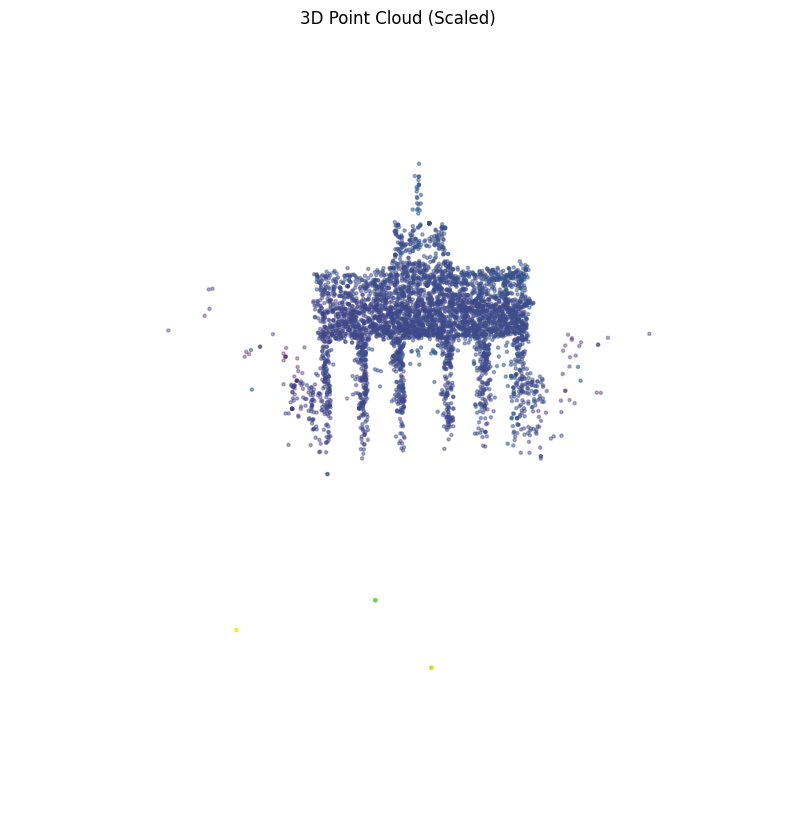

In [84]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

all_points_3D = np.vstack(point_cloud)

# Extract the X, Y, and Z coordinates
x = all_points_3D[:, 0]
y = all_points_3D[:, 1]
z = all_points_3D[:, 2]

# Create a 3D plot
fig = plt.figure(figsize=(10, 11))  # Adjusted figure size for smaller scale
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the 3D points
ax.scatter(x, y, z, c=z, cmap='viridis', s=5)  # Smaller marker size with 's=5'

# Set axis limits to ensure the plot is centered
ax.set_xlim([x.min(), x.max()])  # Set limits based on the data
ax.set_ylim([y.min(), y.max()])
ax.set_zlim([z.min(), z.max()])

# Remove the axes
ax.set_axis_off()

# Set title
ax.set_title('3D Point Cloud (Scaled)')

# Adjust the view angle (top-down view, centered)
ax.view_init(elev=90, azim=90)  # Top-down view with 90-degree azimuth

# Show the plot
plt.show()


In [85]:
import pickle
def save_3d_points_np(Points3d):
    Points3d_array = np.vstack(Points3d)
    np.save('3d_points.npy', Points3d_array)

save_3d_points_np(point_cloud)    

### 3D Reconstruction

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
# add imports here

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:

def load_3d_points_np():
    # return np.load(r'H:\Fall 24\Comp Vision\Project\Task2\3d_points.npy')
    return np.load(r'3d_points.npy')
Points3D = load_3d_points_np()
print(f"Loaded {len(Points3D)} points.")
print(f"Points shape: {Points3D.shape}")
if Points3D.shape[1] != 3:
    raise ValueError("Points3D should have 3 columns corresponding to X, Y, Z coordinates.")
Points3D = Points3D.astype(np.float64)
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(Points3D)
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(point_cloud)
opt = vis.get_render_option()
opt.point_size = 8.0  
vis.run()
vis.destroy_window()




Loaded 4828 points.
Points shape: (4828, 3)


In [16]:
# ply_file_path = r'H:\Fall 24\Comp Vision\Project\Task2\point_cloud.ply'
ply_file_path = r'point_cloud.ply'
o3d.io.write_point_cloud(ply_file_path, point_cloud)
print(f"Point cloud saved as {ply_file_path}")

Point cloud saved as G:\LUMS-MSEE-2022\Semester 5\Project\Git\3d-Landmark-Reconstruction\Task2\point_cloud.ply


### Mesh Generation & Texturing

In [17]:
import open3d as o3d

point_cloud = o3d.io.read_point_cloud(ply_file_path)

print("Estimating normals...")
point_cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
point_cloud.orient_normals_consistent_tangent_plane(100)

print("Performing Poisson surface reconstruction...")
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
    point_cloud, depth=8
)

print("Removing low-density vertices...")
density_threshold = np.mean(densities)  
vertices_to_remove = densities < density_threshold
mesh.remove_vertices_by_mask(vertices_to_remove)

mesh.paint_uniform_color([0.75, 0.75, 0.75])

mesh_file_path = r'meshes\mesh.ply'
o3d.io.write_triangle_mesh(mesh_file_path, mesh)
print(f"Mesh saved as {mesh_file_path}")

o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)


Estimating normals...
Performing Poisson surface reconstruction...
Removing low-density vertices...
Mesh saved as G:\LUMS-MSEE-2022\Semester 5\Project\Git\3d-Landmark-Reconstruction\Task2\mesh.ply


In [18]:
import pymeshlab

ms = pymeshlab.MeshSet()
ms.load_new_mesh(mesh_file_path)

print("Generating UV mapping...")
ms.compute_texcoord_parametrization_triangle_trivial_per_wedge()

uv_mapped_mesh_path = r'meshes\uv_mapped_mesh.obj'
ms.save_current_mesh(uv_mapped_mesh_path, save_vertex_color=False, save_face_color=True)
print(f"UV-mapped mesh saved as {uv_mapped_mesh_path}")


Generating UV mapping...
UV-mapped mesh saved as uv_mapped_mesh.obj
